In [43]:
import os
import pandas as pd
from datetime import datetime, timedelta

import numpy as np
from scipy.stats import linregress
from obspy.clients.fdsn import Client
from obspy import UTCDateTime, read, Stream
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

from tracer import MyStream, plot_traces
from utils import get_csv_events_picks, get_csv_stations

# 1. Input parameters

In [2]:
# Dates
starttime = UTCDateTime(2024, 11, 1)
endtime   = UTCDateTime(2024, 11, 16)
# Seismonitor picks: csv path
    # All picks
sm_picks_fpath = r"\\esg.net\DataShare\ISM\Ecopetrol\ECP_nereidas\SeisMonitor\2024\11-November\picks\eqt\seismonitor_picks.csv" # Load all picks
    # Load just 1 day to save ram
# sm_picks_fpath = r"\\esg.net\DataShare\ISM\Ecopetrol\ECP_nereidas\SeisMonitor\2024\11-November\gamma_asso\eqt\2024-11-04\seismonitor_picks.csv" 
# Inventory: folder with .DATALESS files
inv_folder_path = r"\\esg.net\DataShare\ISM\Ecopetrol\Analytics\eguzmanv\full_response_files\WebSFTP_deliverables\ResponseFiles_WebSFTP_FINAL\nereidas\response_files"

# 2. Catalog

Event and picks

In [3]:
client = Client("http://172.39.20.66:8080")
cat    = client.get_events(starttime        = starttime,
                           endtime          = endtime,
                           includearrivals  = True,
                           includeallorigins= True)
cat

180 Event(s) in Catalog:
2024-11-15T22:17:43.974932Z |  +4.899,  -75.393 | 1.50 ML | manual
2024-11-15T18:11:18.483430Z |  +4.835,  -75.364 | 1.04 ML | manual
...
2024-11-02T03:54:38.637710Z |  +4.880,  -75.352 | 0.44 ML | manual
2024-11-02T03:15:16.269999Z |  +4.523,  -75.953 | 1.91 M  | manual
To see all events call 'print(CatalogObject.__str__(print_all=True))'

In [4]:
events_df, picks_df = get_csv_events_picks(catalog = cat, csv_folder_path = r"\\esg.net\DataShare\ISM\Ecopetrol\Analytics\eguzmanv\seismonitor\data", request_event_type = "earthquake")

Events_csv_file: \\esg.net\DataShare\ISM\Ecopetrol\Analytics\eguzmanv\seismonitor\data\catalog.csv
Picks_csv_file: \\esg.net\DataShare\ISM\Ecopetrol\Analytics\eguzmanv\seismonitor\data\picks.csv


In [10]:
# Filter events_df and picks_df by preferred_origin
events_df = events_df[events_df["preferred_origin"] == "True"]
picks_df  = picks_df[picks_df["preferred_origin"] == "True"]

Stations info

In [6]:
sta_df = get_csv_stations(inv_folder_path = inv_folder_path, csv_fpath = r"\\esg.net\DataShare\ISM\Ecopetrol\Analytics\eguzmanv\seismonitor\data\stations.csv")

Reading inventories ...
\\esg.net\DataShare\ISM\Ecopetrol\Analytics\eguzmanv\full_response_files\WebSFTP_deliverables\ResponseFiles_WebSFTP_FINAL\nereidas\response_files\AUX1_20241105.DATALESS [read]
\\esg.net\DataShare\ISM\Ecopetrol\Analytics\eguzmanv\full_response_files\WebSFTP_deliverables\ResponseFiles_WebSFTP_FINAL\nereidas\response_files\ECO1_20241025.DATALESS [read]
\\esg.net\DataShare\ISM\Ecopetrol\Analytics\eguzmanv\full_response_files\WebSFTP_deliverables\ResponseFiles_WebSFTP_FINAL\nereidas\response_files\ECO2_20241029.DATALESS [read]
\\esg.net\DataShare\ISM\Ecopetrol\Analytics\eguzmanv\full_response_files\WebSFTP_deliverables\ResponseFiles_WebSFTP_FINAL\nereidas\response_files\ECO3_20241106.DATALESS [read]
\\esg.net\DataShare\ISM\Ecopetrol\Analytics\eguzmanv\full_response_files\WebSFTP_deliverables\ResponseFiles_WebSFTP_FINAL\nereidas\response_files\ECO4_20241030.DATALESS [read]
\\esg.net\DataShare\ISM\Ecopetrol\Analytics\eguzmanv\full_response_files\WebSFTP_deliverables\Re

# 3. Tracer

In [7]:
# Requested id
ev_id = "ESG2024vqvj"
# ev_id = "ESG2024vntq"
# ev_id = "ESG2024vqhz"
# ev_id = "ESG2024vrwo"
# Events catalog
events_df_tmp = events_df[(events_df["event_id"] == ev_id) & (events_df["preferred_origin"] == "True")]
    # Origin time [UTC]
OT = UTCDateTime(events_df_tmp.iloc[0, 3]).datetime
    # Coordinates
lon, lat, z = events_df_tmp.iloc[0, 6], events_df_tmp.iloc[0, 4], events_df_tmp.iloc[0, 8]
    # Magnitude
M = events_df_tmp.iloc[0, 14]
# Manual Picks catalog
picks_df_tmp  = picks_df[(picks_df["event_id"] == ev_id) & (picks_df["preferred_origin"] == "True")]
# Seismonitor picks
sm_picks_df = pd.read_csv(sm_picks_fpath, parse_dates = ["arrival_time"])
    # Find the picks values based on a time range (this step can be better in a future)
dt = 5 # [s]
sm_picks_df_tmp = sm_picks_df[(sm_picks_df["arrival_time"] > OT - timedelta(seconds = dt)) & (sm_picks_df["arrival_time"] < OT + timedelta(seconds = dt))]

# Get waveforms
st = Stream()
for i, row in sta_df.iterrows():
    sta = row["station"]
    try:
        st += client.get_waveforms(network  = "EY", 
                                   station  = sta, 
                                   location = "00", 
                                   channel  = "HHZ", 
                                   starttime= UTCDateTime(min(picks_df_tmp["arrival_time"]) - timedelta(seconds = dt/2)),
                                   endtime  = UTCDateTime(max(picks_df_tmp["arrival_time"]) + timedelta(seconds = dt)))
    except:
        continue
st

8 Trace(s) in Stream:
EY.ECO1.00.HHZ | 2024-11-04T01:13:05.420000Z - 2024-11-04T01:13:16.150000Z | 100.0 Hz, 1074 samples
EY.ECO2.00.HHZ | 2024-11-04T01:13:05.420000Z - 2024-11-04T01:13:16.150000Z | 100.0 Hz, 1074 samples
EY.ECO4.00.HHZ | 2024-11-04T01:13:05.420000Z - 2024-11-04T01:13:16.150000Z | 100.0 Hz, 1074 samples
EY.ECO7.00.HHZ | 2024-11-04T01:13:05.420000Z - 2024-11-04T01:13:16.150000Z | 100.0 Hz, 1074 samples
EY.POZ1.00.HHZ | 2024-11-04T01:13:05.420000Z - 2024-11-04T01:13:16.150000Z | 100.0 Hz, 1074 samples
EY.POZ2.00.HHZ | 2024-11-04T01:13:05.420000Z - 2024-11-04T01:13:16.150000Z | 100.0 Hz, 1074 samples
EY.POZ3.00.HHZ | 2024-11-04T01:13:05.420000Z - 2024-11-04T01:13:16.150000Z | 100.0 Hz, 1074 samples
EY.POZ4.00.HHZ | 2024-11-04T01:13:05.420000Z - 2024-11-04T01:13:16.150000Z | 100.0 Hz, 1074 samples

Plot

POZ1 P 2024-11-04 01:13:07.923403 Manual
POZ1 S 2024-11-04 01:13:09.791824 Manual
POZ1 P 2024-11-04 01:13:07.940000 EQTransformer
POZ1 S 2024-11-04 01:13:09.920000 EQTransformer
ECO1 P 2024-11-04 01:13:07.919902 Manual
ECO1 S 2024-11-04 01:13:09.690732 Manual
ECO1 P 2024-11-04 01:13:07.940000 EQTransformer
ECO1 S 2024-11-04 01:13:09.810000 EQTransformer
ECO4 P 2024-11-04 01:13:08.077348 Manual
ECO4 S 2024-11-04 01:13:10.136066 Manual
ECO4 P 2024-11-04 01:13:08.110000 EQTransformer
ECO4 S 2024-11-04 01:13:10.300000 EQTransformer
POZ2 P 2024-11-04 01:13:08.050541 Manual
POZ2 S 2024-11-04 01:13:09.872967 Manual
POZ2 P 2024-11-04 01:13:08.050000 EQTransformer
POZ2 S 2024-11-04 01:13:10.040000 EQTransformer
POZ3 P 2024-11-04 01:13:08.191936 Manual
POZ3 S 2024-11-04 01:13:10.258513 Manual
POZ3 P 2024-11-04 01:13:08.250000 EQTransformer
POZ3 S 2024-11-04 01:13:10.400000 EQTransformer
ECO2 P 2024-11-04 01:13:08.199433 Manual
ECO2 S 2024-11-04 01:13:10.152405 Manual
ECO2 P 2024-11-04 01:13:08.2

(<Figure size 1200x1200 with 8 Axes>,
 array([<Axes: title={'center': 'ID: ESG2024vqvj, OT: 2024-11-04 01:13:05.597849 UTC, ML earthquake\nLat: 4.93°, Lon: -75.36°, Depth: 5.1 km'}>,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: xlabel='Time [UTC]'>], dtype=object))

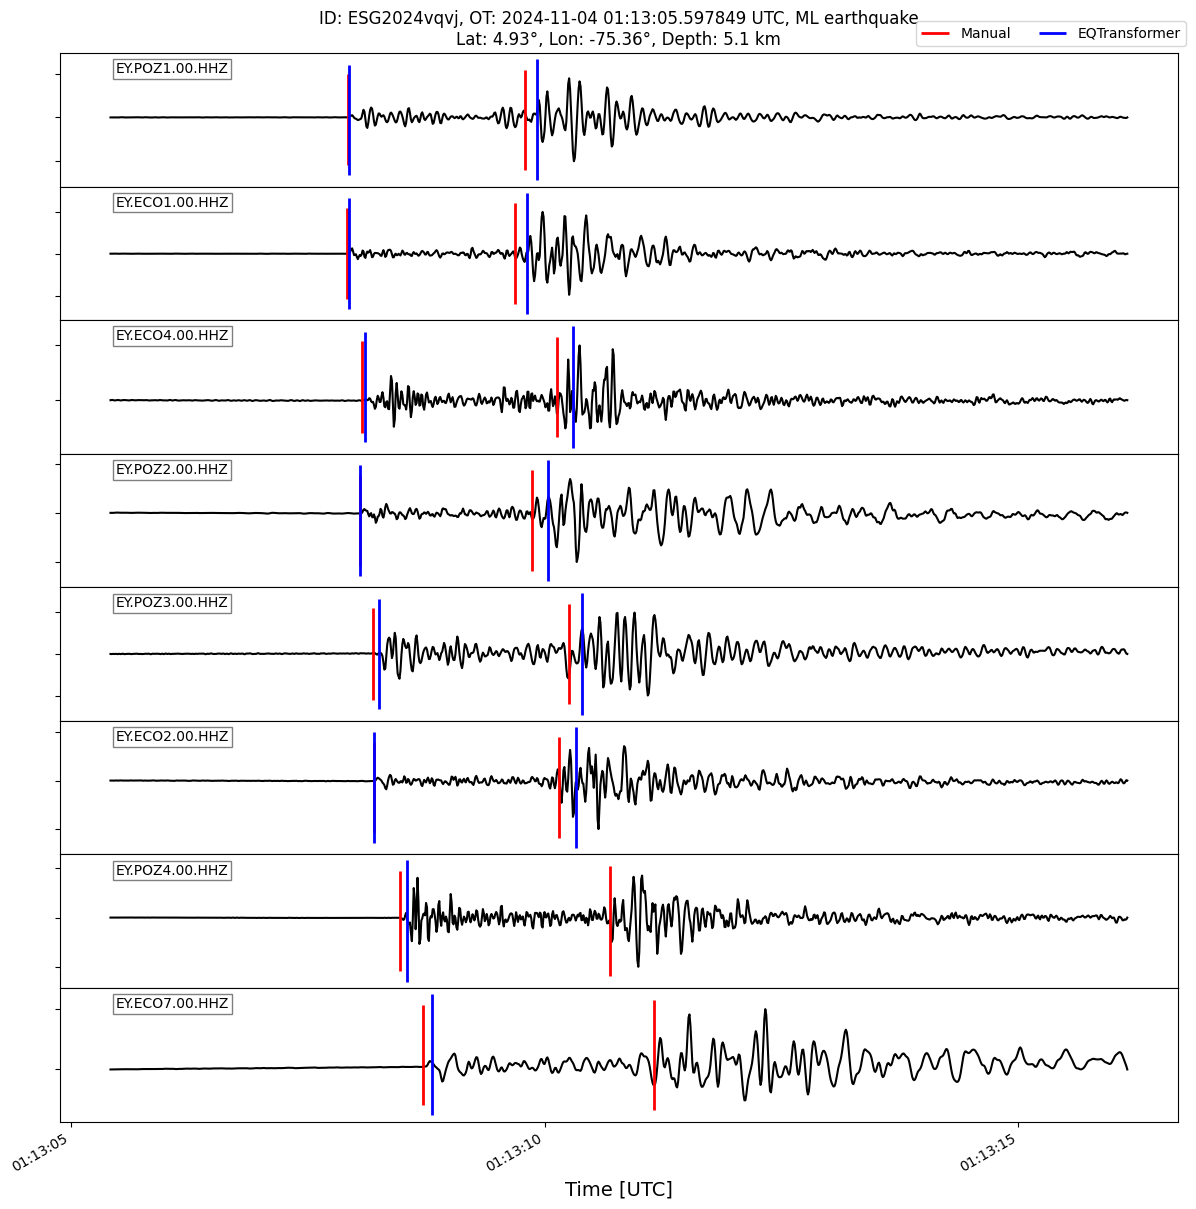

In [9]:
myst = MyStream(st.traces, sta_df)
myst.sort_from_source(source=(lon,lat))
myst.detrend().normalize()
picks_list = {"Manual" : picks_df_tmp, "EQTransformer": sm_picks_df_tmp}
color_authors = {"Manual": {"P": "red", "S": "red"}, "EQTransformer": {"P": "blue", "S": "blue"}}

title = f"ID: {ev_id}, OT: {OT} UTC, ML {M}\nLat: {round(lat, 2)}°, Lon: {round(lon, 2)}°, Depth: {round(z/1000, 1)} km"
# title = f"ID: {ev_id} | OT: {OT} UTC | ML {M}\nLat: {round(lat, 2)}°, Lon: {round(lon, 2)}°, Depth: {round(z/1000, 1)} km"
plot_traces(myst, picks_list, color_authors, title, show = False, savefig = rf"\\esg.net\DataShare\ISM\Ecopetrol\Analytics\eguzmanv\seismonitor\figs\tracer\{ev_id}.jpg")

# 4. Catalog - Analysis

Histogram

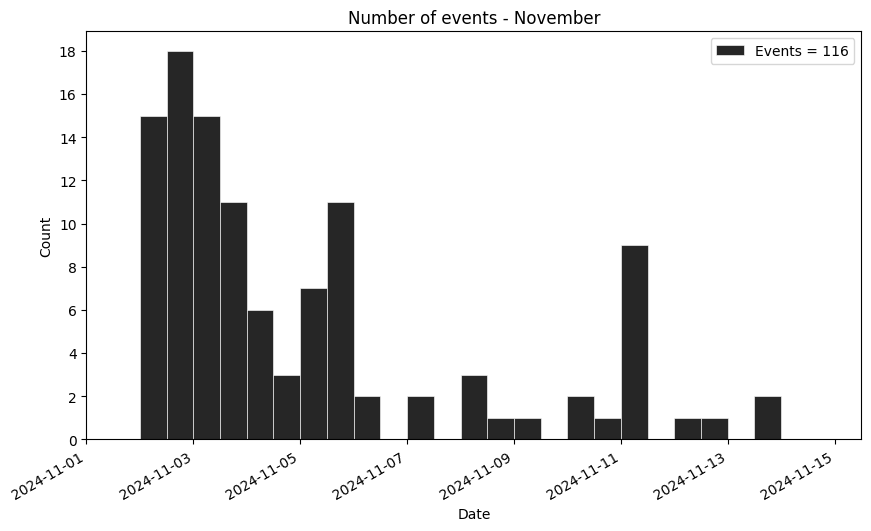

In [30]:
plt.figure(figsize = (10, 6))
plt.hist(events_df["event_time"], range=(starttime.datetime, endtime.datetime), bins = mdates.drange(starttime.datetime, endtime.datetime, pd.Timedelta(hours=12)), 
         color = "k", edgecolor = "w", alpha = 0.85, linewidth = 0.5, label = f"Events = {len(events_df['magnitude'])}")
plt.ylabel("Count")
plt.xlabel("Date")
plt.gca().autoscale(enable=True, axis='x', tight=True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Number of events - November")
plt.legend()
plt.savefig(os.path.join(r"\\esg.net\DataShare\ISM\Ecopetrol\Analytics\eguzmanv\seismonitor\figs\catalog", "hist.jpg"), bbox_inches = "tight", dpi = 300)
plt.show()

Map

In [23]:
xlim_degree = [-75.50665, -75.33341]
ylim_degree = [4.81182, 4.95932]
result_label = "Manual"

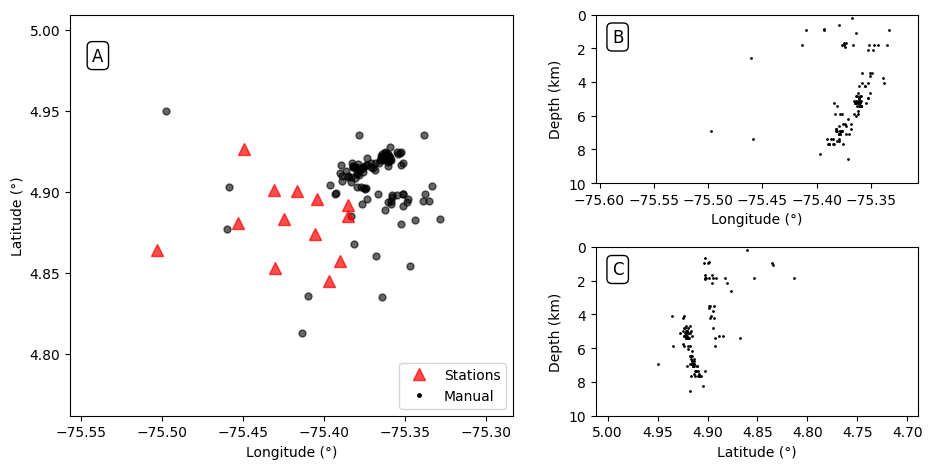

In [36]:
fig = plt.figure(figsize=plt.rcParams["figure.figsize"]*np.array([1.5,1]))
box = dict(boxstyle='round', facecolor='white', alpha=1)
text_loc = [0.05, 0.92]
grd = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[1.5, 1], height_ratios=[1,1])
fig.add_subplot(grd[:, 0])
plt.plot(events_df["longitude"], events_df["latitude"], 'k.', markersize=10, alpha=0.6)
plt.axis("scaled")
plt.xlim(np.array(xlim_degree)+np.array([-0.05,0.05]))
plt.ylim(np.array(ylim_degree)+np.array([-0.05,0.05]))
# plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()

plt.xlabel("Longitude (°)")
plt.ylabel("Latitude (°)")
plt.gca().set_prop_cycle(None)
plt.plot(sta_df["longitude"], sta_df["latitude"], 'r^', markersize=8, alpha=0.7, label="Stations")
plt.plot(xlim_degree[0]-1, ylim_degree[0]-1, 'k.', markersize = 5, label = f"{result_label}")#, rasterized=True)
plt.legend(loc="lower right")
plt.text(text_loc[0], text_loc[1], 'A', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)


fig.add_subplot(grd[0, 1])
plt.plot(events_df["longitude"], events_df["depth"]/1e3, 'k.', markersize=2, alpha=1.0, rasterized=True)
# plt.axis("scaled")
plt.xlim(np.array(xlim_degree)+np.array([0.2,-0.27]))
plt.ylim([0,10])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xlabel("Longitude (°)")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot(xlim_degree[0]-10, 31, 'k.', markersize=10)
plt.text(text_loc[0], text_loc[1], 'B', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)

fig.add_subplot(grd[1, 1])
plt.plot(events_df["latitude"], events_df["depth"]/1e3, 'k.', markersize=2, alpha=1.0, rasterized=True)
# plt.axis("scaled")
plt.xlim(np.array(ylim_degree)+np.array([0.2,-0.27]))
plt.ylim([0,10])
plt.gca().invert_yaxis()
plt.xlabel("Latitude (°)")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot(ylim_degree[0]-10, 31, '.', markersize=10)
plt.tight_layout()
plt.text(text_loc[0], text_loc[1], 'C', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
plt.savefig(r"\\esg.net\DataShare\ISM\Ecopetrol\Analytics\eguzmanv\seismonitor\figs\catalog\map.jpg", bbox_inches="tight", dpi=300)
plt.show()

Magnitude

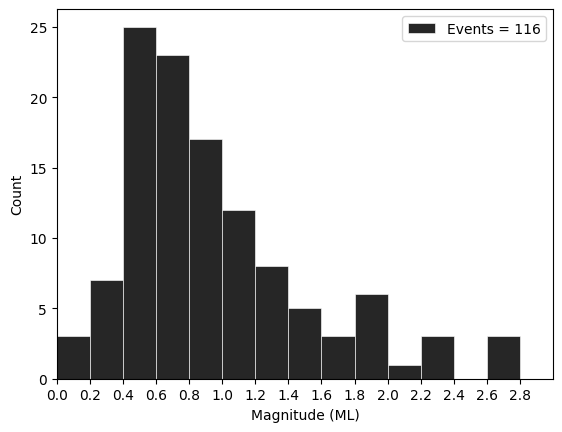

In [29]:
plt.figure()
plt.hist(events_df["magnitude"], range=(0., 3), bins = np.arange(0, 3.0, 0.2), color = "k", edgecolor="w", 
         linewidth=0.5, alpha = 0.85, label = f"Events = {len(events_df['magnitude'])}")
plt.xticks(np.arange(0, 3.0, 0.2))
plt.legend()
plt.xlim([0,3])
plt.xlabel(r"Magnitude (ML)")
plt.ylabel("Count")
plt.savefig(r"\\esg.net\DataShare\ISM\Ecopetrol\Analytics\eguzmanv\seismonitor\figs\catalog\mag.jpg", bbox_inches="tight", dpi=300)
plt.show()

Wadati

In [94]:
# ---------------------------- Save Wadati data ----------------------------
# Create empty lists of data
t_SP_list = []
t_P_list  = []

# Loop: go through each event in events_df
for ev_idx, ev_row in events_df.iterrows():
    # Event id
    ev_id = ev_row["event_id"]
    # Origin time [UTC]
    OT = UTCDateTime(str(ev_row["event_time"]))
    # Picks
        # All picks
    picks_df_tmp = picks_df[picks_df["event_id"] == ev_id]
        # P picks
    picks_df_tmp2= picks_df_tmp[picks_df_tmp["phasehint"] == "P"]
            # Loop: go through each pick in dataframe filtered by P
    for pick_idx, pick_row in picks_df_tmp2.iterrows():
                # Sta code
        sta    = pick_row["station"]
                # Pick - arrival times
                    # P
        P_time = UTCDateTime(str(pick_row["arrival_time"]))
                    # S
        try: 
            S_time_str = str(picks_df_tmp[(picks_df_tmp["phasehint"] == "S") & (picks_df_tmp["station"] == sta)]["arrival_time"].values[0])
            S_time     = UTCDateTime(S_time_str)
        except: continue
        # Append calculation to lists        
        t_P_list.append(P_time - OT)
        t_SP_list.append(S_time - P_time)
        
# Save data as .npz file
fpath = r"\\esg.net\DataShare\ISM\Ecopetrol\Analytics\eguzmanv\seismonitor\data\wadati.npz"
np.savez(fpath, t_P = t_P_list, t_SP = t_SP_list)
print(f"{fpath} [saved]")

\\esg.net\DataShare\ISM\Ecopetrol\Analytics\eguzmanv\seismonitor\data\wadati.npz [saved]


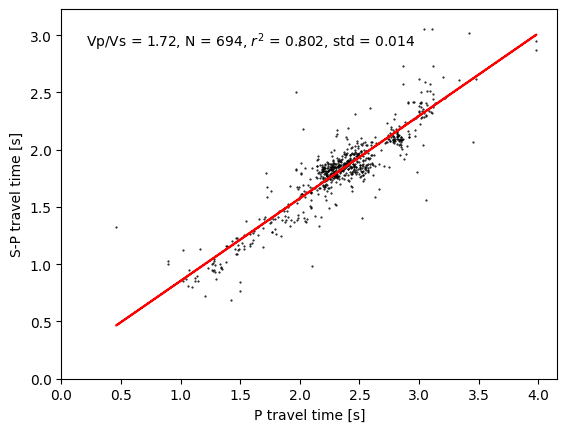

In [100]:
# ---------------------------- Read Wadati data ----------------------------
# Read data
fpath = r"\\esg.net\DataShare\ISM\Ecopetrol\Analytics\eguzmanv\seismonitor\data\wadati.npz"
t = np.load(fpath)
t_P, t_SP = t['t_P'], t['t_SP']
# Compute linear regression y = mx + b
m, b, r, p, std_err = linregress(t_P, t_SP)

y = m * t_P + b

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x = t_P, y = t_SP, marker = '.', color = 'k', s = 1.0)
ax.plot(t_P, y, color = 'r')
ax.text(0.05, 0.9, fr'Vp/Vs = {round(1 + m, 2)}, N = {len(t_P)}, $r^2$ = {round(r ** 2, 3)}, std = {round(std_err, 3)}', transform = ax.transAxes)
ax.set_xlabel('P travel time [s]')
ax.set_ylabel('S-P travel time [s]')
ax.set_xlim(0)
ax.set_ylim(0)
fig.savefig(fname = "figs\catalog\wadati.jpg", dpi = 300)
plt.show()